In [1]:
# !pip install tqdm rich

In [2]:
"""
Safety RL with MiniGrid - Implementation of Fisac et al. ICRA 2019
"Bridging Hamilton-Jacobi Safety Analysis and Reinforcement Learning"

Key Innovation: Use discounted min-over-time formulation to learn safe sets
Core Equation: Q(s,a) = min(l(s,a), γ * max_a' Q(s', a'))
where l(s,a) is the immediate safety cost
"""

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
import minigrid
from minigrid.wrappers import ImgObsWrapper, FlatObsWrapper
from stable_baselines3 import PPO, DQN
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
import matplotlib.pyplot as plt
from collections import deque
import os

In [3]:
class SafetyQNetwork(nn.Module):
    """
    Safety Q-Network: learns Q(state, action) for safety
    
    Q-value interpretation:
    - Q(s,a) <= 0 → state-action is SAFE
    - Q(s,a) > 0  → state-action is UNSAFE (will lead to constraint violation)
    """
    
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(SafetyQNetwork, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)  # Output Q-value for each action
        )
        
    def forward(self, state):
        """Returns Q-values for all actions given a state"""
        return self.network(state)

In [4]:
class SafetyQLearning:
    """
    Safety Q-Learning based on Fisac et al.
    
    Modified Bellman Operator:
    Q(s,a) = min(l(s,a), γ * max_a' Q(s', a'))
    
    where:
    - l(s,a) = immediate safety cost (0 if safe, 1 if hit lava)
    - γ = discount factor
    """
    
    def __init__(self, state_dim, action_dim, lr=3e-4, gamma=0.95, device='cpu'):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.device = device
        
        # Q-network and target network
        self.q_network = SafetyQNetwork(state_dim, action_dim).to(device)
        self.target_network = SafetyQNetwork(state_dim, action_dim).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        
        # Replay buffer for safety experiences
        self.replay_buffer = deque(maxlen=10000)
        self.batch_size = 64
        
        # Metrics
        self.losses = []
        
    def add_experience(self, state, action, next_state, safety_cost, done):
        """Add experience to replay buffer"""
        self.replay_buffer.append((state, action, next_state, safety_cost, done))
    
    def update(self):
        """
        Update safety Q-network using modified Bellman operator
        
        Key difference from standard Q-learning:
        Instead of: Q(s,a) = r + γ*max_a' Q(s',a')
        We use:     Q(s,a) = min(cost, γ*max_a' Q(s',a'))
        
        This implements the "min-over-time" safety objective
        """
        if len(self.replay_buffer) < self.batch_size:
            return None
        
        # Sample batch
        batch = np.random.choice(len(self.replay_buffer), self.batch_size, replace=False)
        states, actions, next_states, costs, dones = [], [], [], [], []
        
        for idx in batch:
            s, a, ns, c, d = self.replay_buffer[idx]
            states.append(s)
            actions.append(a)
            next_states.append(ns)
            costs.append(c)
            dones.append(d)
        
        # Convert to tensors
        states = torch.FloatTensor(np.array(states)).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        next_states = torch.FloatTensor(np.array(next_states)).to(self.device)
        costs = torch.FloatTensor(costs).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)
        
        # Current Q-values: Q(s, a)
        current_q = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze()
        
        # Compute target using MODIFIED BELLMAN OPERATOR (Fisac et al.)
        with torch.no_grad():
            # max_a' Q(s', a')
            next_q_values = self.target_network(next_states)
            max_next_q = next_q_values.max(dim=1)[0]
            
            # Modified Bellman: min(cost, γ * V(s'))
            # This is THE KEY INNOVATION from the paper
            discounted_future = self.gamma * max_next_q * (1 - dones)
            target_q = torch.min(costs, discounted_future)
        
        # Loss and update
        loss = nn.MSELoss()(current_q, target_q)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.losses.append(loss.item())
        return loss.item()
    
    def update_target_network(self, tau=0.005):
        """Soft update of target network"""
        for target_param, param in zip(self.target_network.parameters(), 
                                       self.q_network.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
    
    def is_safe(self, state, action):
        """
        Check if state-action pair is safe
        
        Returns:
        - True if Q(s,a) <= 0 (safe)
        - False if Q(s,a) > 0 (unsafe)
        """
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.q_network(state_tensor)
            q_value = q_values[0, action].item()
        return q_value <= 0.0
    
    def get_safe_action(self, state, available_actions):
        """
        Get safest action from available actions
        Returns action with lowest (most negative) Q-value
        """
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.q_network(state_tensor)[0]
        
        # Get Q-values for available actions
        q_vals = [q_values[a].item() for a in available_actions]
        safest_idx = np.argmin(q_vals)
        return available_actions[safest_idx], q_vals[safest_idx]




In [5]:
class SafetyTrainingCallback(BaseCallback):
    """
    Callback to train safety critic alongside task policy
    
    This runs during PPO/DQN training and:
    1. Collects transitions (state, action, next_state, safety_cost)
    2. Updates safety Q-network
    3. Logs safety metrics
    """
    
    def __init__(self, safety_critic, update_freq=1, verbose=0):
        super().__init__(verbose)
        self.safety_critic = safety_critic
        self.update_freq = update_freq
        
        # Metrics tracking
        self.episode_violations = []
        self.current_episode_violations = 0
        self.safety_values = []
        self.num_updates = 0
        
    def _on_step(self) -> bool:
        """Called at each environment step"""
        
        # Extract transition data
        # Note: need to handle both new_obs and obs properly
        if 'infos' in self.locals and len(self.locals['infos']) > 0:
            info = self.locals['infos'][0]
            
            # Get state, action, next_state
            if 'new_obs' in self.locals:
                next_state = self.locals['new_obs'][0]
            else:
                next_state = None
                
            if 'obs_tensor' in self.locals:
                state = self.locals['obs_tensor'][0].cpu().numpy()
            else:
                return True
                
            action = self.locals['actions'][0]
            done = self.locals['dones'][0]
            
            # Compute safety cost
            # In MiniGrid with lava: cost = 1 if hit lava, 0 otherwise
            safety_cost = 0.0
            if 'hit_lava' in info:
                safety_cost = 1.0 if info['hit_lava'] else 0.0
                if info['hit_lava']:
                    self.current_episode_violations += 1
            
            # Add to safety critic's replay buffer
            if next_state is not None:
                self.safety_critic.add_experience(
                    state, action, next_state, safety_cost, done
                )
            
            # Update safety critic
            if self.n_calls % self.update_freq == 0:
                loss = self.safety_critic.update()
                if loss is not None:
                    self.num_updates += 1
                    
                # Update target network
                self.safety_critic.update_target_network()
            
            # Track episode completion
            if done:
                self.episode_violations.append(self.current_episode_violations)
                self.current_episode_violations = 0
        
        return True
    
    def _on_training_end(self):
        print("[DEBUG] Callback _on_training_end called")
        return
        """Print summary at end of training"""
#         print("\n" + "="*60)
#         print("SAFETY CRITIC TRAINING SUMMARY")
#         print("="*60)
#         if len(self.episode_violations) > 0:
#             print(f"Total Episodes: {len(self.episode_violations)}")
#             print(f"Total Violations: {sum(self.episode_violations)}")
#             print(f"Average Violations per Episode: {np.mean(self.episode_violations):.2f}")
#             print(f"Safety Critic Updates: {self.num_updates}")
#         if len(self.safety_critic.losses) > 0:
#             print(f"Final Safety Loss: {np.mean(self.safety_critic.losses[-100:]):.4f}")


In [6]:
# class RewardShapingWrapper(gym.Wrapper):
#     """Give small rewards for exploration"""
#     def __init__(self, env):
#         super().__init__(env)
#         self.prev_pos = None
        
#     def reset(self, **kwargs):
#         obs, info = self.env.reset(**kwargs)
#         self.prev_pos = self.env.unwrapped.agent_pos
#         return obs, info
    
#     def step(self, action):
#         obs, reward, terminated, truncated, info = self.env.step(action)
        
#         # Reward for moving to new position
#         curr_pos = self.env.unwrapped.agent_pos
#         if curr_pos != self.prev_pos:
#             reward += 0.01  # Small reward for moving
        
#         self.prev_pos = curr_pos
#         return obs, reward, terminated, truncated, info
class RewardShapingWrapper(gym.Wrapper):
    """Give small rewards for exploration"""
    def __init__(self, env):
        super().__init__(env)
        self.prev_pos = None
        
    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.prev_pos = tuple(self.env.unwrapped.agent_pos)  # Convert to tuple
        return obs, info
    
    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        
        # Reward for moving to new position
        curr_pos = tuple(self.env.unwrapped.agent_pos)  # Convert to tuple
        
        # FIX: Use tuple comparison
        if curr_pos != self.prev_pos:
            reward += 0.01  # Small reward for moving
        
        self.prev_pos = curr_pos
        return obs, reward, terminated, truncated, info

In [7]:
class LavaDetectorWrapper(gym.Wrapper):
    """
    Wrapper to detect when agent steps on lava
    Adds 'hit_lava' to info dict
    """
    
    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        
        # Check if agent is on lava
        hit_lava = False
        if hasattr(self.env.unwrapped, 'grid'):
            agent_pos = self.env.unwrapped.agent_pos
            cell = self.env.unwrapped.grid.get(*agent_pos)
            if cell is not None and cell.type == 'lava':
                hit_lava = True
        
        info['hit_lava'] = hit_lava
        
        return obs, reward, terminated, truncated, info


In [8]:
def make_safe_env(env_name="MiniGrid-LavaCrossingS9N1-v0", render_mode=None):
    env = gym.make(env_name, render_mode=render_mode)
    env = LavaDetectorWrapper(env)
    env = RewardShapingWrapper(env)
    env = FlatObsWrapper(env)  
    env = Monitor(env)
    return env

# def make_safe_env(env_name="MiniGrid-LavaCrossingS9N1-v0", render_mode=None):
#     env = gym.make(env_name, render_mode=render_mode)
#     env = LavaDetectorWrapper(env)

#     env = FlatObsWrapper(env)
#     env = Monitor(env)
#     return env

In [9]:
def train_safe_rl(env_name="MiniGrid-LavaCrossingS9N1-v0", total_timesteps=50000, 
                  algorithm="PPO", save_dir="/mnt/user-data/outputs"):
    print("\n" + "="*70)
    print("SAFETY RL - Fisac et al. on MiniGrid")
    print("="*70)
    
    print(f"\n[1/5] Creating environment: {env_name}")
    env = make_safe_env(env_name)
    
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    print(f"      State dim: {state_dim}, Action dim: {action_dim}")
    
    print("\n[2/5] Initializing Safety Q-Learning")
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"      Device: {device}")
    
    safety_critic = SafetyQLearning(
        state_dim=state_dim,
        action_dim=action_dim,
        lr=3e-4,
        gamma=0.95,
        device=device
    )
    
    print(f"\n[3/5] Initializing {algorithm}")
    if algorithm == "PPO":
        model = PPO("MlpPolicy", env, verbose=1, learning_rate=3e-4,
                   n_steps=128, batch_size=64, n_epochs=4, gamma=0.99)
    else:
        model = DQN("MlpPolicy", env, verbose=1, learning_rate=1e-4,
                   buffer_size=50000, learning_starts=1000, batch_size=64, gamma=0.99)
    
    safety_callback = SafetyTrainingCallback(safety_critic=safety_critic, update_freq=1)
    
    print(f"\n[4/5] Training for {total_timesteps} timesteps...\n")
    
    print("[DEBUG] About to call model.learn()...")
    model.learn(total_timesteps=total_timesteps, callback=safety_callback, progress_bar=False)
    print("[DEBUG] model.learn() completed!")
    
    print("[DEBUG] Training loop finished, starting save process...")
    
    print(f"\n[5/5] Saving...")
    os.makedirs(save_dir, exist_ok=True)
    
    print("[DEBUG] Saving task policy...")
    model.save(f"{save_dir}/task_policy")
    print("[DEBUG] Task policy saved")
    
    print("[DEBUG] Saving safety critic...")
    torch.save(safety_critic.q_network.state_dict(), f"{save_dir}/safety_critic.pth")
    print("[DEBUG] Safety critic saved")
    
    print("[DEBUG] Saving metrics...")
    np.save(f"{save_dir}/safety_losses.npy", np.array(safety_critic.losses))
    np.save(f"{save_dir}/violations.npy", np.array(safety_callback.episode_violations))
    print("[DEBUG] Metrics saved")
    
    print(f"✓ Saved to {save_dir}/")
    print("[DEBUG] About to return from train_safe_rl")
    
    return model, safety_critic, env

In [10]:
def evaluate_safety(model, safety_critic, env_name, n_episodes=10, render=False, max_steps=500):
    """
    Evaluate trained policy with safety analysis
    """
    print("\n" + "="*70)
    print("SAFETY EVALUATION")
    print("="*70)
    
    render_mode = "human" if render else None
    env = make_safe_env(env_name, render_mode=render_mode)
    
    results = {
        'episodes': [],
        'violations': [],
        'rewards': [],
        'steps': [],
        'success': []
    }
    
    for ep in range(n_episodes):
        print(f"Evaluating episode {ep+1}/{n_episodes}...", end=" ")
        
        obs, info = env.reset()
        done = False
        episode_reward = 0
        episode_violations = 0
        episode_steps = 0
        success = False
        
        while not done:
            # Get action from policy
            action, _ = model.predict(obs, deterministic=True)
            
            # Take action
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            episode_reward += reward
            episode_steps += 1
            
            if info.get('hit_lava', False):
                episode_violations += 1
            
            if reward > 0.9:  
                success = True
            
            # ADD MAX STEPS LIMIT TO PREVENT INFINITE LOOPS
            if episode_steps >= max_steps:
                print(f"(hit max steps)", end=" ")
                done = True
                break
        
        results['episodes'].append(ep)
        results['violations'].append(episode_violations)
        results['rewards'].append(episode_reward)
        results['steps'].append(episode_steps)
        results['success'].append(success)
        
        status = "✓" if success else "✗"
        print(f"{status} | Violations: {episode_violations} | "
              f"Reward: {episode_reward:.1f} | Steps: {episode_steps}")
    
    print("\n" + "-"*70)
    print("SUMMARY:")
    print(f"  Success Rate:         {np.mean(results['success'])*100:.1f}%")
    print(f"  Avg Violations/Ep:    {np.mean(results['violations']):.2f}")
    print(f"  Avg Reward:           {np.mean(results['rewards']):.2f}")
    print(f"  Avg Steps:            {np.mean(results['steps']):.1f}")
    print("-"*70)
    
    env.close()
    return results

In [11]:
def visualize(save_dir="./outputs"):
    """Create visualization of training results"""
    print("[DEBUG] Loading data for visualization...")
    
    losses = np.load(f"{save_dir}/safety_losses.npy")
    violations = np.load(f"{save_dir}/violations.npy")
    
    print(f"[DEBUG] Loaded {len(losses)} losses, {len(violations)} violation records")
    
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    # Plot 1: Safety Critic Loss
    ax = axes[0]
    if len(losses) > 100:
        smoothed = np.convolve(losses, np.ones(100)/100, mode='valid')
        ax.plot(smoothed, linewidth=2, label='Smoothed Loss')
    ax.plot(losses, alpha=0.3, label='Raw Loss')
    ax.set_xlabel('Update Step')
    ax.set_ylabel('Safety Critic Loss')
    ax.set_title('Safety Q-Network Training Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Safety Violations per Episode
    ax = axes[1]
    ax.plot(violations, alpha=0.6, marker='o', markersize=3)
    
    if len(violations) > 10:
        smoothed = np.convolve(violations, np.ones(10)/10, mode='valid')
        ax.plot(range(9, len(violations)), smoothed, 'r-', linewidth=2, label='Moving Avg')
    
    ax.axhline(y=0, color='g', linestyle='--', alpha=0.5, label='Zero Violations')
    ax.set_xlabel('Episode')
    ax.set_ylabel('Violations (Lava Hits)')
    ax.set_title('Safety Violations During Training')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    save_path = f"{save_dir}/results.png"
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"[DEBUG] Saved plot to {save_path}")
    
    return fig

In [12]:
# Configuration
ENV_NAME = "MiniGrid-LavaCrossingS9N1-v0"
# ENV_NAME = "MiniGrid-Empty-8x8-v0" 
ALGORITHM = "PPO"
TIMESTEPS = 10000
SAVE_DIR = "./outputs"  # Changed to local directory for easier access

print(f"📋 Configuration:")
print(f"   Environment: {ENV_NAME}")
print(f"   Algorithm: {ALGORITHM}")
print(f"   Timesteps: {TIMESTEPS}")

📋 Configuration:
   Environment: MiniGrid-LavaCrossingS9N1-v0
   Algorithm: PPO
   Timesteps: 10000


In [13]:
# Train with debug checkpoints
print("\n" + "▶"*35 + " TRAINING " + "◀"*35)
print("[DEBUG] Starting train_safe_rl...")

model, safety_critic, env = train_safe_rl(
    env_name=ENV_NAME,
    total_timesteps=TIMESTEPS,
    algorithm=ALGORITHM,
    save_dir=SAVE_DIR
)

print("[DEBUG] train_safe_rl returned successfully")
print("[DEBUG] Closing environment...")

env.close()  # Explicitly close environment

print("[DEBUG] Environment closed")
print("\n✓ Training complete!")
print(f"✓ Models saved to {SAVE_DIR}/")


▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶ TRAINING ◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀
[DEBUG] Starting train_safe_rl...

SAFETY RL - Fisac et al. on MiniGrid

[1/5] Creating environment: MiniGrid-LavaCrossingS9N1-v0
      State dim: 2835, Action dim: 7

[2/5] Initializing Safety Q-Learning
      Device: cpu

[3/5] Initializing PPO
Using cpu device
Wrapping the env in a DummyVecEnv.

[4/5] Training for 10000 timesteps...

[DEBUG] About to call model.learn()...


/var/folders/4q/kkl9vg_x7djbb289kx8rn8h00000gn/T/ipykernel_5983/3407521895.py:67: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  dones = torch.FloatTensor(dones).to(self.device)


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 88       |
|    ep_rew_mean     | 0.11     |
| time/              |          |
|    fps             | 439      |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 128      |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 69.3          |
|    ep_rew_mean          | 0.08          |
| time/                   |               |
|    fps                  | 382           |
|    iterations           | 2             |
|    time_elapsed         | 0             |
|    total_timesteps      | 256           |
| train/                  |               |
|    approx_kl            | 0.00020180084 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.95         |
|    explained_variance   | -16.3         |


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 92            |
|    ep_rew_mean          | 0.191         |
| time/                   |               |
|    fps                  | 335           |
|    iterations           | 11            |
|    time_elapsed         | 4             |
|    total_timesteps      | 1408          |
| train/                  |               |
|    approx_kl            | 0.00052499305 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.93         |
|    explained_variance   | -0.604        |
|    learning_rate        | 0.0003        |
|    loss                 | 0.0028        |
|    n_updates            | 40            |
|    policy_gradient_loss | -0.00265      |
|    value_loss           | 0.0286        |
-------------------------------------------
-------------------------------------------
| rollout/                |     

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 117          |
|    ep_rew_mean          | 0.196        |
| time/                   |              |
|    fps                  | 334          |
|    iterations           | 21           |
|    time_elapsed         | 8            |
|    total_timesteps      | 2688         |
| train/                  |              |
|    approx_kl            | 0.0013746405 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.9         |
|    explained_variance   | -4.01        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0181      |
|    n_updates            | 80           |
|    policy_gradient_loss | -0.00746     |
|    value_loss           | 0.00442      |
------------------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_l

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 92.6          |
|    ep_rew_mean          | 0.162         |
| time/                   |               |
|    fps                  | 328           |
|    iterations           | 30            |
|    time_elapsed         | 11            |
|    total_timesteps      | 3840          |
| train/                  |               |
|    approx_kl            | 0.00047193188 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.84         |
|    explained_variance   | -4.12         |
|    learning_rate        | 0.0003        |
|    loss                 | -0.00319      |
|    n_updates            | 116           |
|    policy_gradient_loss | -0.000511     |
|    value_loss           | 0.00342       |
-------------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 95.9         |
|    ep_rew_mean          | 0.171        |
| time/                   |              |
|    fps                  | 322          |
|    iterations           | 40           |
|    time_elapsed         | 15           |
|    total_timesteps      | 5120         |
| train/                  |              |
|    approx_kl            | 0.0020109443 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.72        |
|    explained_variance   | -2.55        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00624     |
|    n_updates            | 156          |
|    policy_gradient_loss | -0.00394     |
|    value_loss           | 0.00303      |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 90.4         |
|    ep_rew_mean          | 0.183        |
| time/                   |              |
|    fps                  | 318          |
|    iterations           | 50           |
|    time_elapsed         | 20           |
|    total_timesteps      | 6400         |
| train/                  |              |
|    approx_kl            | 0.0017793183 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.73        |
|    explained_variance   | -0.191       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0159       |
|    n_updates            | 196          |
|    policy_gradient_loss | 0.000364     |
|    value_loss           | 0.0346       |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 80.8         |
|    ep_rew_mean          | 0.186        |
| time/                   |              |
|    fps                  | 316          |
|    iterations           | 60           |
|    time_elapsed         | 24           |
|    total_timesteps      | 7680         |
| train/                  |              |
|    approx_kl            | 0.0005908329 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.67        |
|    explained_variance   | -2.18        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.000608     |
|    n_updates            | 236          |
|    policy_gradient_loss | -0.00244     |
|    value_loss           | 0.014        |
------------------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_l

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 57           |
|    ep_rew_mean          | 0.177        |
| time/                   |              |
|    fps                  | 314          |
|    iterations           | 70           |
|    time_elapsed         | 28           |
|    total_timesteps      | 8960         |
| train/                  |              |
|    approx_kl            | 0.0022023935 |
|    clip_fraction        | 0.00781      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.31        |
|    explained_variance   | -1.16        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0152      |
|    n_updates            | 276          |
|    policy_gradient_loss | -0.00362     |
|    value_loss           | 0.00602      |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

[DEBUG] Callback _on_training_end called
[DEBUG] model.learn() completed!
[DEBUG] Training loop finished, starting save process...

[5/5] Saving...
[DEBUG] Saving task policy...
[DEBUG] Task policy saved
[DEBUG] Saving safety critic...
[DEBUG] Safety critic saved
[DEBUG] Saving metrics...
[DEBUG] Metrics saved
✓ Saved to ./outputs/
[DEBUG] About to return from train_safe_rl
[DEBUG] train_safe_rl returned successfully
[DEBUG] Closing environment...
[DEBUG] Environment closed

✓ Training complete!
✓ Models saved to ./outputs/


Loading saved metrics...
✓ Loaded 10049 loss values, 158 episodes

Creating visualizations...
[DEBUG] Loading data for visualization...
[DEBUG] Loaded 10049 losses, 158 violation records
[DEBUG] Saved plot to ./outputs/results.png
✓ Visualizations created!


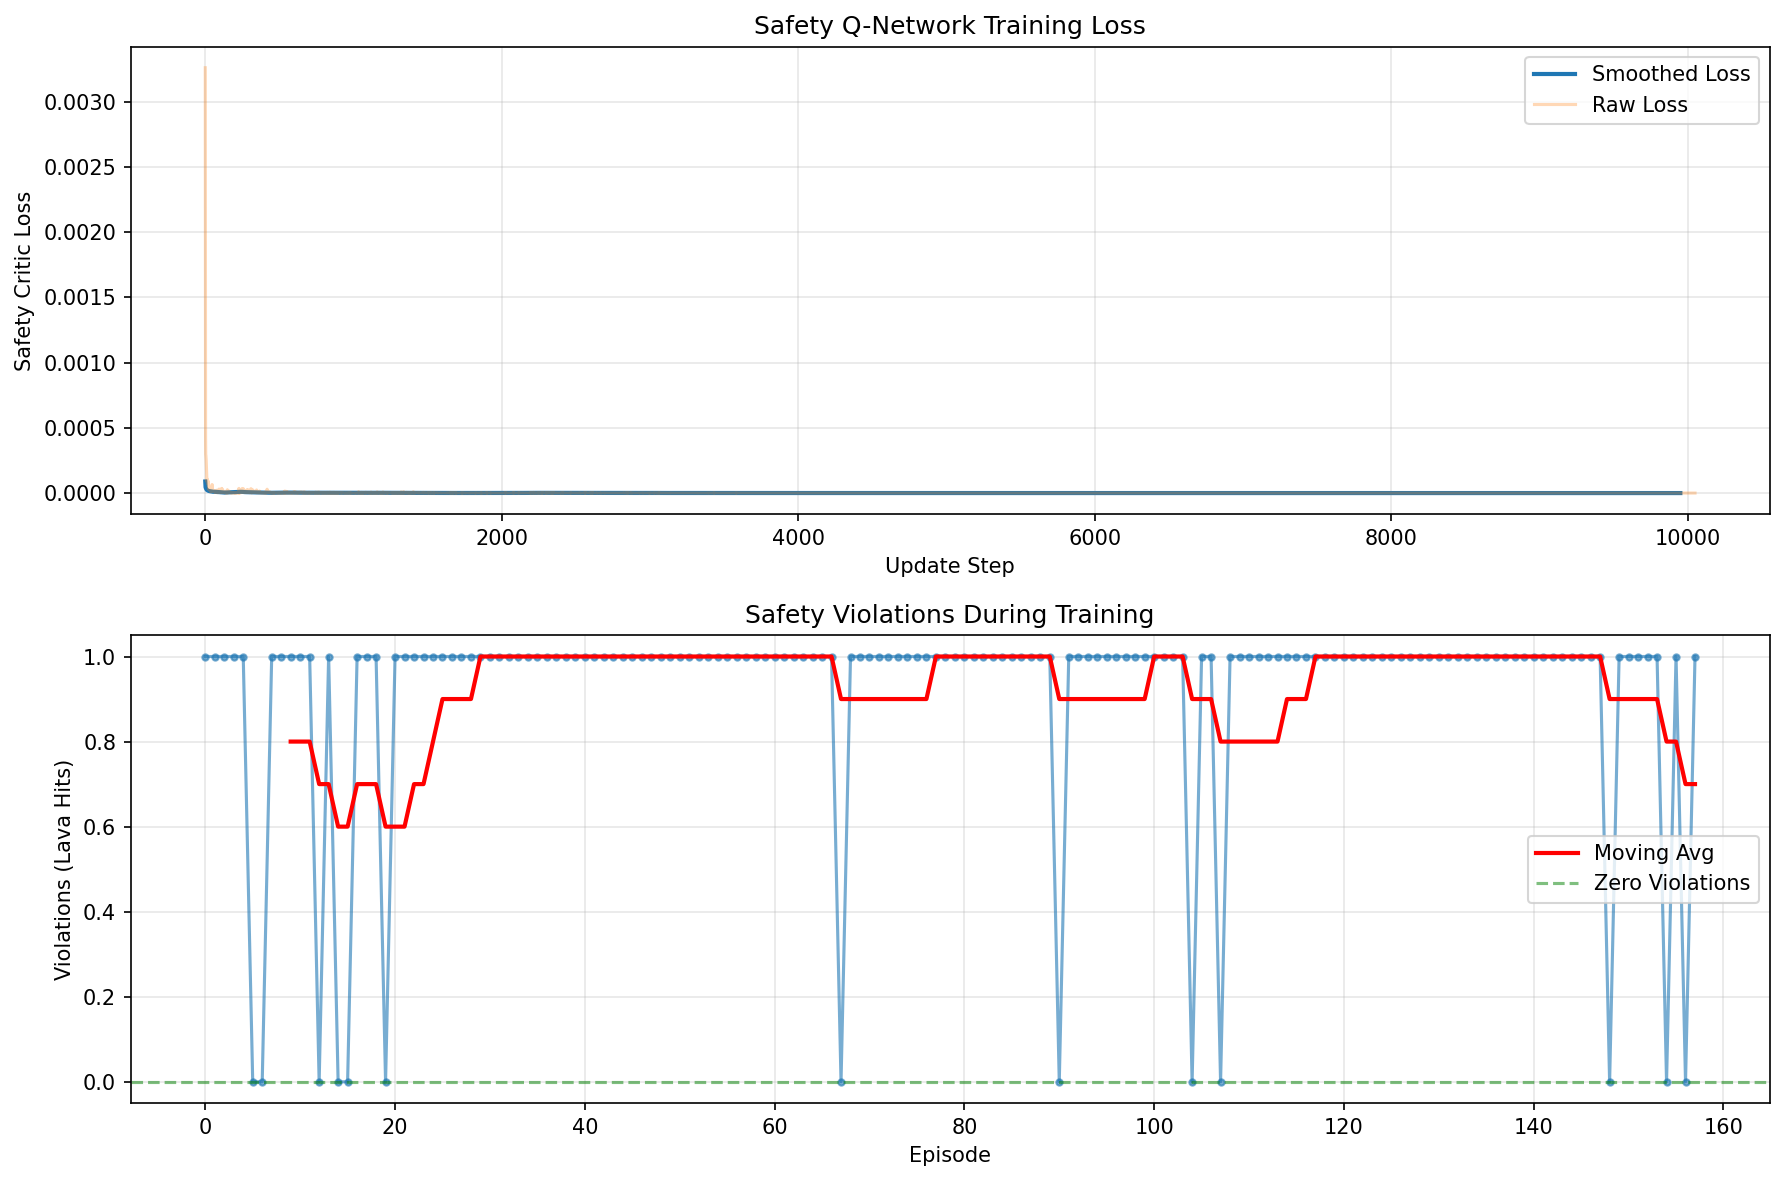

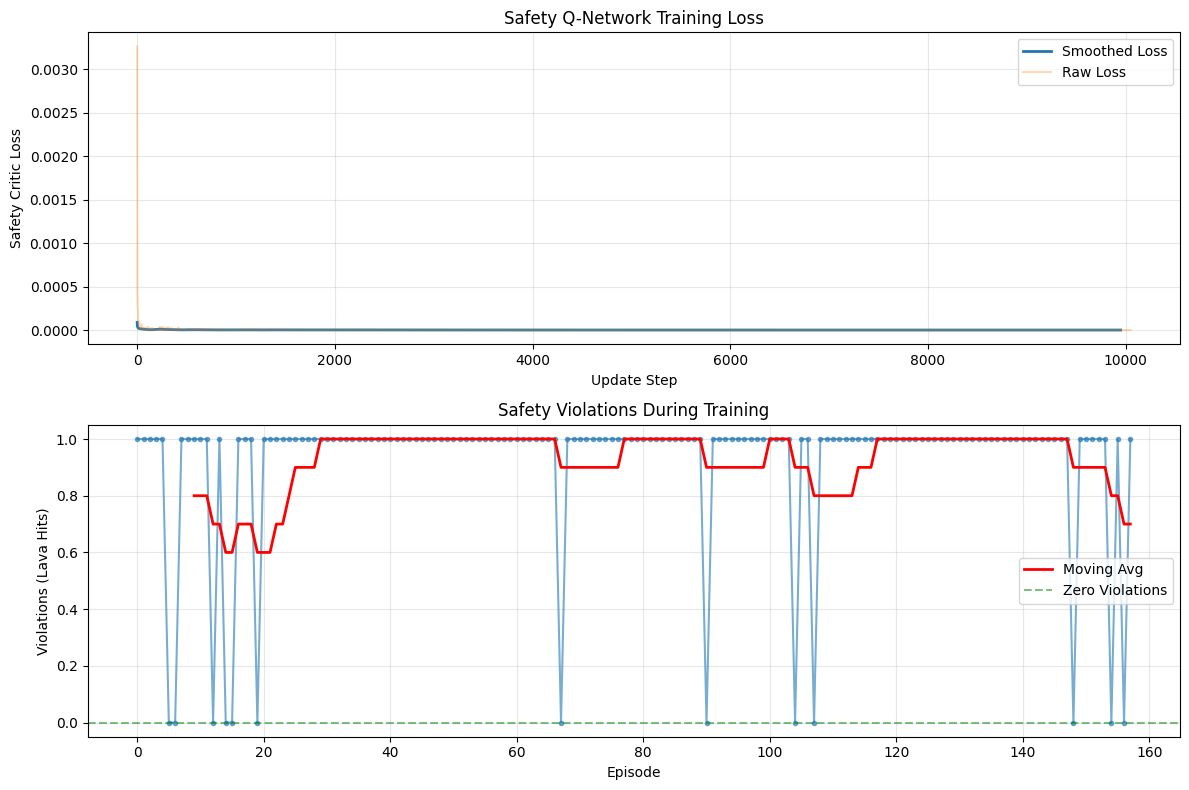

In [14]:
# Load saved metrics
print("Loading saved metrics...")
safety_losses = np.load(f"{SAVE_DIR}/safety_losses.npy")
episode_violations = np.load(f"{SAVE_DIR}/violations.npy")
print(f"✓ Loaded {len(safety_losses)} loss values, {len(episode_violations)} episodes")

# Visualize
print("\nCreating visualizations...")
visualize(SAVE_DIR)  # Changed from visualize_results to visualize
print("✓ Visualizations created!")

# Display the plot in Jupyter
from IPython.display import Image, display
display(Image(filename=f"{SAVE_DIR}/results.png"))

In [15]:
# Evaluate
print("\n" + "▶"*35 + " EVALUATION " + "◀"*34)
print("Starting evaluation (should take ~30-60 seconds)...")

results = evaluate_safety(
    model, 
    safety_critic, 
    ENV_NAME,
    n_episodes=10,
    render=False,
    max_steps=500
)

print("\n✅ EVALUATION COMPLETE!")


▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶ EVALUATION ◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀
Starting evaluation (should take ~30-60 seconds)...

SAFETY EVALUATION
Evaluating episode 1/10... ✗ | Violations: 1 | Reward: 0.0 | Steps: 1
Evaluating episode 2/10... ✗ | Violations: 1 | Reward: 0.0 | Steps: 1
Evaluating episode 3/10... ✗ | Violations: 1 | Reward: 0.0 | Steps: 3
Evaluating episode 4/10... ✗ | Violations: 1 | Reward: 0.0 | Steps: 1
Evaluating episode 5/10... ✗ | Violations: 0 | Reward: 0.1 | Steps: 324
Evaluating episode 6/10... ✗ | Violations: 0 | Reward: 0.1 | Steps: 324
Evaluating episode 7/10... ✗ | Violations: 0 | Reward: 0.1 | Steps: 324
Evaluating episode 8/10... ✗ | Violations: 0 | Reward: 0.1 | Steps: 324
Evaluating episode 9/10... ✗ | Violations: 0 | Reward: 0.1 | Steps: 324
Evaluating episode 10/10... ✗ | Violations: 0 | Reward: 0.1 | Steps: 324

----------------------------------------------------------------------
SUMMARY:
  Success Rate:         0.0%
  Avg Violations/Ep:   

In [16]:
# Print summary
print("\n" + "="*80)
print("📚 What You've Implemented (Fisac et al.):")
print("   1. ✓ Modified Bellman operator: Q(s,a) = min(cost, γ*V(s'))")
print("   2. ✓ Safety Q-learning with discrete actions")
print("   3. ✓ Parallel training of task policy + safety critic")
print("   4. ✓ Safety evaluation and metrics")

print("\n💡 For Your Meeting with Haimin:")
print("   → Explain the min() operator (key innovation)")
print("   → Show how Q-values indicate safe vs unsafe")
print("   → Discuss scaling to continuous control")
print("   → Ask about their research directions")
print("="*80)


📚 What You've Implemented (Fisac et al.):
   1. ✓ Modified Bellman operator: Q(s,a) = min(cost, γ*V(s'))
   2. ✓ Safety Q-learning with discrete actions
   3. ✓ Parallel training of task policy + safety critic
   4. ✓ Safety evaluation and metrics

💡 For Your Meeting with Haimin:
   → Explain the min() operator (key innovation)
   → Show how Q-values indicate safe vs unsafe
   → Discuss scaling to continuous control
   → Ask about their research directions


In [17]:
# import time

# # Watch the agent in slow motion
# test_env = make_safe_env(ENV_NAME, render_mode="human")
# obs, _ = test_env.reset()

# print("Starting episode... (watch for the window to pop up)")
# print(f"Initial observation shape: {obs.shape}")

# for step in range(100):
#     action, _ = model.predict(obs, deterministic=True)
#     print(f"Step {step}: Action = {action}", end="\r")  # Show action being taken
    
#     obs, reward, terminated, truncated, info = test_env.step(action)
    
#     # Force render and add delay to see movement
#     test_env.render()
#     time.sleep(0.1)  # 100ms delay between steps
    
#     if terminated or truncated:
#         print(f"\nEpisode ended at step {step}")
#         break

# test_env.close()
# print("Done!")

In [18]:
# # See what's ACTUALLY happening
# test_env = gym.make("MiniGrid-Empty-8x8-v0", render_mode="human")
# obs, _ = test_env.reset()

# print(f"Initial agent position: {test_env.unwrapped.agent_pos}")
# print(f"Initial agent direction: {test_env.unwrapped.agent_dir}")
# print(f"Goal position: {test_env.unwrapped.goal_pos if hasattr(test_env.unwrapped, 'goal_pos') else 'Unknown'}")

# for step in range(10):
#     print(f"\nStep {step}: Taking action 2 (forward)")
#     print(f"  Before: pos={test_env.unwrapped.agent_pos}, dir={test_env.unwrapped.agent_dir}")
    
#     obs, reward, terminated, truncated, info = test_env.step(2)
    
#     print(f"  After:  pos={test_env.unwrapped.agent_pos}, dir={test_env.unwrapped.agent_dir}")
#     print(f"  Reward: {reward}, Done: {terminated or truncated}")
    
#     if terminated or truncated:
#         print("EPISODE ENDED!")
#         break

# test_env.close()

In [19]:
# # Check what actions the agent takes
# test_env = make_safe_env(ENV_NAME, render_mode=None)
# obs, _ = test_env.reset()

# actions = []
# positions = []
# rewards = []

# for step in range(50):
#     action, _ = model.predict(obs, deterministic=True)
#     actions.append(action)
    
#     # Get position before step
#     pos_before = tuple(test_env.unwrapped.agent_pos)
    
#     obs, reward, terminated, truncated, info = test_env.step(action)
#     rewards.append(reward)
    
#     # Get position after step
#     pos_after = tuple(test_env.unwrapped.agent_pos)
#     positions.append((pos_before, pos_after))
    
#     if terminated or truncated:
#         break

# test_env.close()

# # Analyze
# action_names = {0: "left", 1: "right", 2: "forward", 3: "pick", 4: "drop", 5: "toggle", 6: "done"}
# print(f"Actions taken: {[action_names.get(a, a) for a in actions[:20]]}")
# print(f"Unique actions: {set(actions)}")
# print(f"Total reward: {sum(rewards)}")
# print(f"Rewards per step: {rewards[:20]}")
# print(f"\nPosition changes:")
# for i in range(min(10, len(positions))):
#     before, after = positions[i]
#     moved = "MOVED" if before != after else "STUCK"
#     print(f"  Step {i}: {before} → {after} ({moved}), reward={rewards[i]}")

In [20]:
# Check if violations decreased during training
violations = np.load(f"{SAVE_DIR}/violations.npy")
print(f"Violations - First 10 eps: {violations[:10]}")
print(f"Violations - Last 10 eps: {violations[-10:]}")
print(f"Average: {violations[:10].mean():.2f} → {violations[-10:].mean():.2f}")

Violations - First 10 eps: [1 1 1 1 1 0 0 1 1 1]
Violations - Last 10 eps: [0 1 1 1 1 1 0 1 0 1]
Average: 0.80 → 0.70
